# CRACTERIZACIÓN EN BASE A ANALISIS DE TEXTURA

## PREPROCESAMIENTO

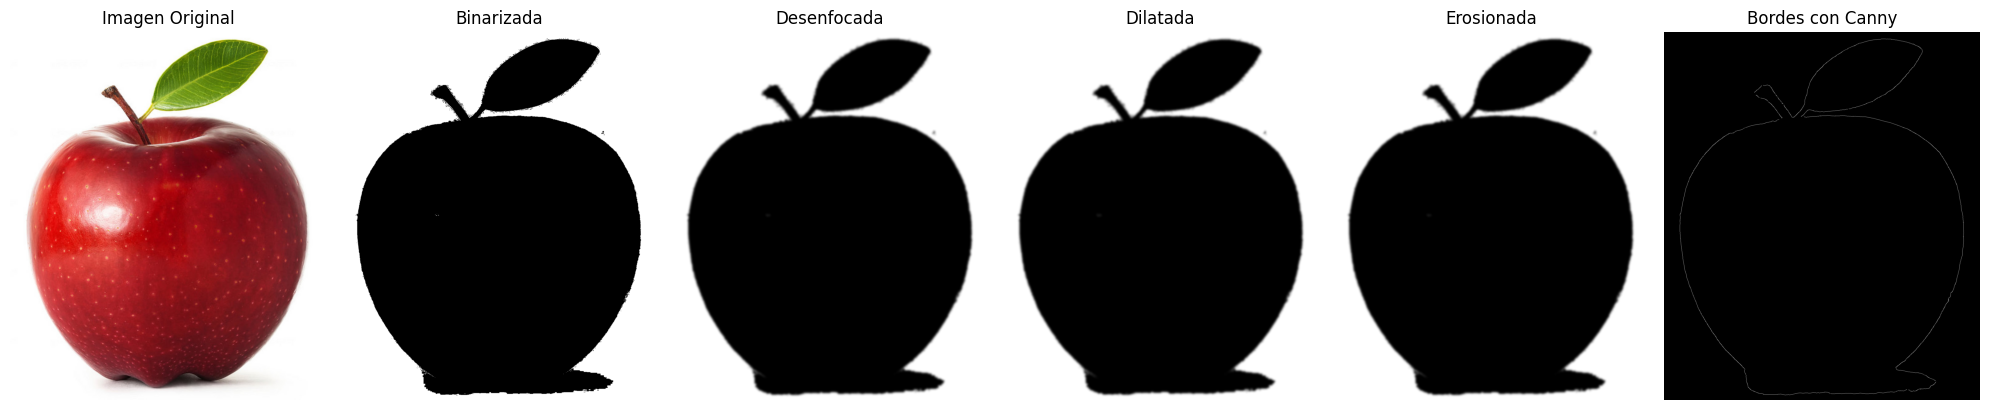

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen
imagen = cv2.imread('APL1.jpg')  # Reemplaza con la ruta de tu imagen
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para matplotlib

# Convertir a escala de grises
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Binarizar la imagen (usar un umbral adaptativo o fijo)
_, binarizada = cv2.threshold(gris, 250, 255, cv2.THRESH_BINARY)

# Aplicar desenfoque Gaussiano para reducir ruido
desenfocada = cv2.GaussianBlur(binarizada, (31,31), 0)

# Crear un kernel para operaciones morfológicas
kernel = np.ones((3,3), np.uint8)  # Matriz de 3x3 de unos

# Aplicar dilatación
dilatada = cv2.dilate(desenfocada, kernel, iterations=1)

# Aplicar erosión
erosionada = cv2.erode(dilatada, kernel, iterations=1)

# Aplicar el detector de bordes Canny después de la erosión
bordes = cv2.Canny(erosionada, 50, 150)

# Mostrar imágenes con Matplotlib
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

axs[0].imshow(imagen_rgb)  
axs[0].set_title("Imagen Original")
axs[0].axis("off")

axs[1].imshow(binarizada, cmap='gray')  
axs[1].set_title("Binarizada")
axs[1].axis("off")

axs[2].imshow(desenfocada, cmap='gray')  
axs[2].set_title("Desenfocada")
axs[2].axis("off")

axs[3].imshow(dilatada, cmap='gray')  
axs[3].set_title("Dilatada")
axs[3].axis("off")

axs[4].imshow(erosionada, cmap='gray')  
axs[4].set_title("Erosionada")
axs[4].axis("off")

axs[5].imshow(bordes, cmap='gray')  
axs[5].set_title("Bordes con Canny")
axs[5].axis("off")

plt.tight_layout()
plt.show()

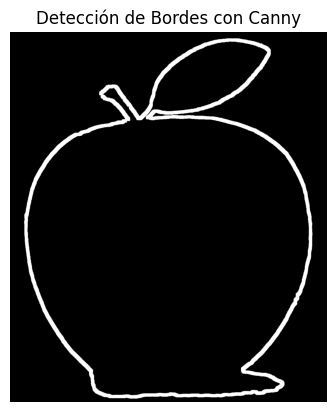

In [2]:
kernel = np.ones((3,3), np.uint8)
bordes_dilatados = cv2.dilate(bordes, kernel, iterations=7)
# Mostrar resultado
plt.imshow(bordes_dilatados, cmap='gray')
plt.title("Detección de Bordes con Canny")
plt.axis('off')
plt.show()

##### Entropía, la energía y la inercia con coocurencia y furier, LBP, SIFT AND SUF

Características de textura guardadas en: descriptores_textura.csv


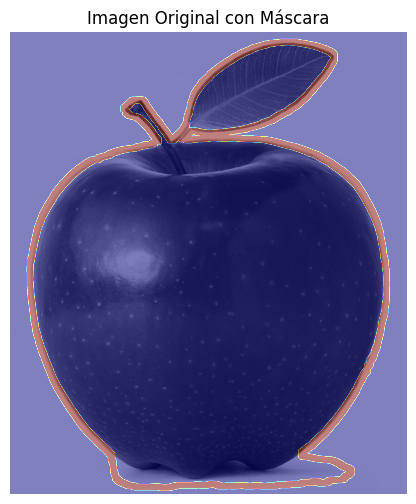

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
import csv
import os

# Cargar imagen original
directorio_imagen = 'APL1.jpg'
imagen_original = cv2.imread(directorio_imagen, cv2.IMREAD_GRAYSCALE)

# Supongamos que ya tienes 'bordes_dilatados'
mascara = cv2.dilate(bordes_dilatados, np.ones((5, 5), np.uint8), iterations=2)
mascara = cv2.threshold(mascara, 127, 255, cv2.THRESH_BINARY)[1]

# Aplicar máscara a la imagen
roi = cv2.bitwise_and(imagen_original, imagen_original, mask=mascara)

# Normalizar ROI
niveles = 256
roi_normalizado = (roi / roi.max() * (niveles - 1)).astype(np.uint8)

# --- Cálculo de características ---
distancias = [1]
angulos = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm = graycomatrix(roi_normalizado, distances=distancias, angles=angulos, levels=niveles, symmetric=True, normed=True)
energia = graycoprops(glcm, 'energy').mean()
inercia = graycoprops(glcm, 'contrast').mean()
entropia = shannon_entropy(roi_normalizado)

# Transformada de Fourier
fft = np.fft.fft2(roi)
fourier_energy = np.sum(np.abs(fft) ** 2)

# LBP
radius = 3
n_points = 8 * radius
lbp = local_binary_pattern(roi, n_points, radius, method='uniform')
lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
lbp_hist = lbp_hist / lbp_hist.sum()

# SIFT
sift = cv2.SIFT_create()
keypoints, _ = sift.detectAndCompute(roi, None)
n_keypoints_sift = len(keypoints)

# ORB
orb = cv2.ORB_create()
keypoints, _ = orb.detectAndCompute(roi, None)
n_keypoints_orb = len(keypoints)

# Diccionario de características
descriptores_textura = {
    "Entropia": entropia,
    "Energia_GLCM": energia,
    "Inercia_GLCM": inercia,
    "Fourier_Energy": fourier_energy,
    "LBP_Histogram": lbp_hist.tolist(),
    "SIFT_Keypoints": n_keypoints_sift,
    "ORB_Keypoints": n_keypoints_orb,
}

# --- Guardar en CSV ---
nombre_archivo = "descriptores_textura.csv"
modo = 'a' if os.path.exists(nombre_archivo) else 'w'

with open(nombre_archivo, mode=modo, newline="") as archivo_csv:
    escritor = csv.writer(archivo_csv)
    if modo == 'w':  # Crear nuevo archivo si no existe
        escritor.writerow(descriptores_textura.keys())
    escritor.writerow([entropia, energia, inercia, fourier_energy, lbp_hist.tolist(), n_keypoints_sift, n_keypoints_orb])

print(f"Características de textura guardadas en: {nombre_archivo}")

# --- Mostrar imagen con máscara sobrepuesta ---
plt.figure(figsize=(6, 6))
plt.imshow(imagen_original, cmap='gray')
plt.imshow(mascara, cmap='jet', alpha=0.5)  # Superponer máscara en color
plt.title("Imagen Original con Máscara")
plt.axis('off')
plt.show()


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
import csv

# Supongamos que ya tienes 'bordes_dilatados' del código anterior.
# Crear máscara del objeto
mascara = cv2.dilate(bordes_dilatados, np.ones((5, 5), np.uint8), iterations=2)
mascara = cv2.threshold(mascara, 127, 255, cv2.THRESH_BINARY)[1]

# Extraer región de interés (ROI)
imagen_original = cv2.imread('APL1.jpg', cv2.IMREAD_GRAYSCALE)  # Reemplazar por la imagen original
roi = cv2.bitwise_and(imagen_original, imagen_original, mask=mascara)

# Normalizar ROI para GLCM
niveles = 256
roi_normalizado = (roi / roi.max() * (niveles - 1)).astype(np.uint8)

# --- Cálculo de características ---
# 1. Coocurrencia (GLCM): Entropía, Energía, Inercia
distancias = [1]
angulos = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm = graycomatrix(roi_normalizado, distances=distancias, angles=angulos, levels=niveles, symmetric=True, normed=True)
energia = graycoprops(glcm, 'energy').mean()
inercia = graycoprops(glcm, 'contrast').mean()
entropia = shannon_entropy(roi_normalizado)

# 2. Descriptores de Fourier
fft = np.fft.fft2(roi)
fft_magnitude = np.abs(fft)
fourier_energy = np.sum(fft_magnitude ** 2)

# 3. LBP (Local Binary Patterns)
radius = 3
n_points = 8 * radius
lbp = local_binary_pattern(roi, n_points, radius, method='uniform')
lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
lbp_hist = lbp_hist / lbp_hist.sum()

# 4. SIFT
sift = cv2.SIFT_create()
keypoints, descriptors_sift = sift.detectAndCompute(roi, None)
n_keypoints_sift = len(keypoints)

# 5. ORB (reemplazando SURF)
orb = cv2.ORB_create()
keypoints, descriptors_orb = orb.detectAndCompute(roi, None)
n_keypoints_orb = len(keypoints)

# --- Guardar características en CSV ---
descriptores_textura = {
    "Entropia": entropia,
    "Energia_GLCM": energia,
    "Inercia_GLCM": inercia,
    "Fourier_Energy": fourier_energy,
    "LBP_Histogram": lbp_hist.tolist(),
    "SIFT_Keypoints": n_keypoints_sift,
    "ORB_Keypoints": n_keypoints_orb,  # Cambiado de SURF a ORB
}

nombre_archivo = "descriptores_textura.csv"
with open(nombre_archivo, mode="w", newline="") as archivo_csv:
    escritor = csv.writer(archivo_csv)
    escritor.writerow(descriptores_textura.keys())
    escritor.writerow([entropia, energia, inercia, fourier_energy, lbp_hist.tolist(), n_keypoints_sift, n_keypoints_orb])

print(f"Características de textura guardadas en: {nombre_archivo}")



Características de textura guardadas en: descriptores_textura.csv
